In [1]:
# import packages
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.interpolate import interp1d

### Voltage waveform

In [2]:
filename = '~/projects/mcell/simple_geom/input_waveform_data/pre_ap_voltage.txt'
v_m_df = pd.read_csv(filename, delim_whitespace=True, header=None)
v_m = v_m_df.to_numpy()

In [3]:
print("The minimum voltage reached is %.2f" % v_m.min())
print("The maximum voltage reached is %.2f" % v_m.max())

The minimum voltage reached is -72.73
The maximum voltage reached is 53.42


### Interpolation

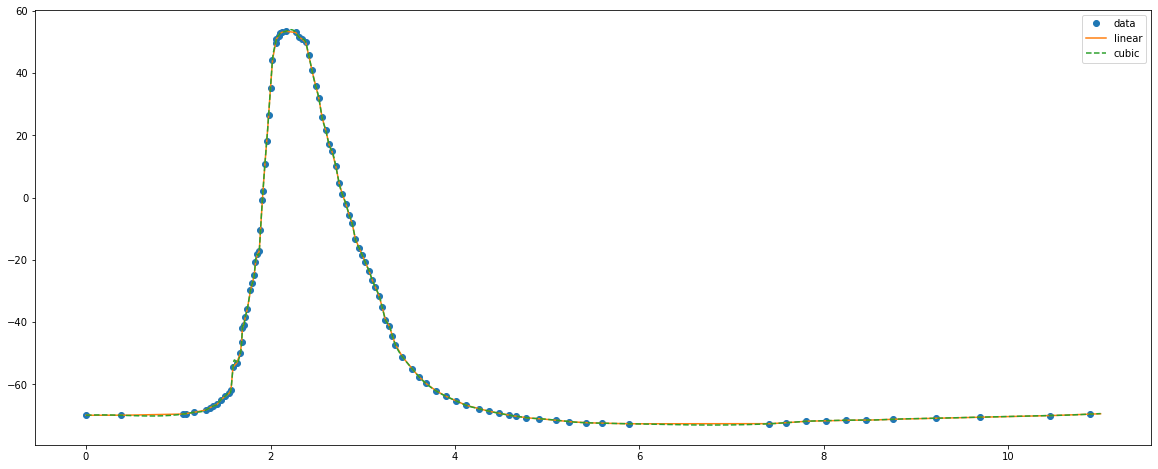

In [4]:
vm_lin_interp = interp1d(v_m[:,0]*1000, v_m[:,1], fill_value="extrapolate")
vm_cubic_interp = interp1d(v_m[:,0]*1000, v_m[:,1], kind = 'cubic',fill_value="extrapolate")
tnew = np.arange(0, 11, 1e-3)

plt.figure(figsize=(20,8))
plt.plot(v_m[:,0]*1000, v_m[:,1], 'o', tnew, vm_lin_interp(tnew), '-', tnew, vm_cubic_interp(tnew), '--')

plt.legend(['data', 'linear', 'cubic','nearest'], loc = 'best')

plt.show()

In [5]:
v_m = vm_cubic_interp
trange = tnew

### Transitions
Using actual txt files instead of functions.

In [6]:
filename = '~/projects/mcell/simple_geom/input_waveform_data/hva_pre_a1.txt'
a1 = pd.read_csv(filename, delim_whitespace=True)
a1 = a1.to_numpy()

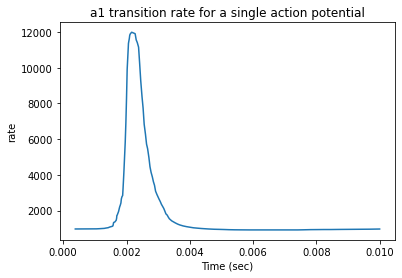

In [7]:
plt.plot(a1[:,0],a1[:,1])
plt.title('a1 transition rate for a single action potential')
plt.xlabel('Time (sec)')
plt.ylabel('rate')
plt.show()

In [8]:
# Create dictionary of data values for each transition waveform
data_dir = '/Users/margotwagner/projects/mcell/simple_geom/input_waveform_data'
input_data = {}

for filename in os.listdir(data_dir):
    data = pd.read_csv(os.path.join(data_dir, filename), delim_whitespace=True)
    input_data[filename.split('.txt')[0]] = data.to_numpy()

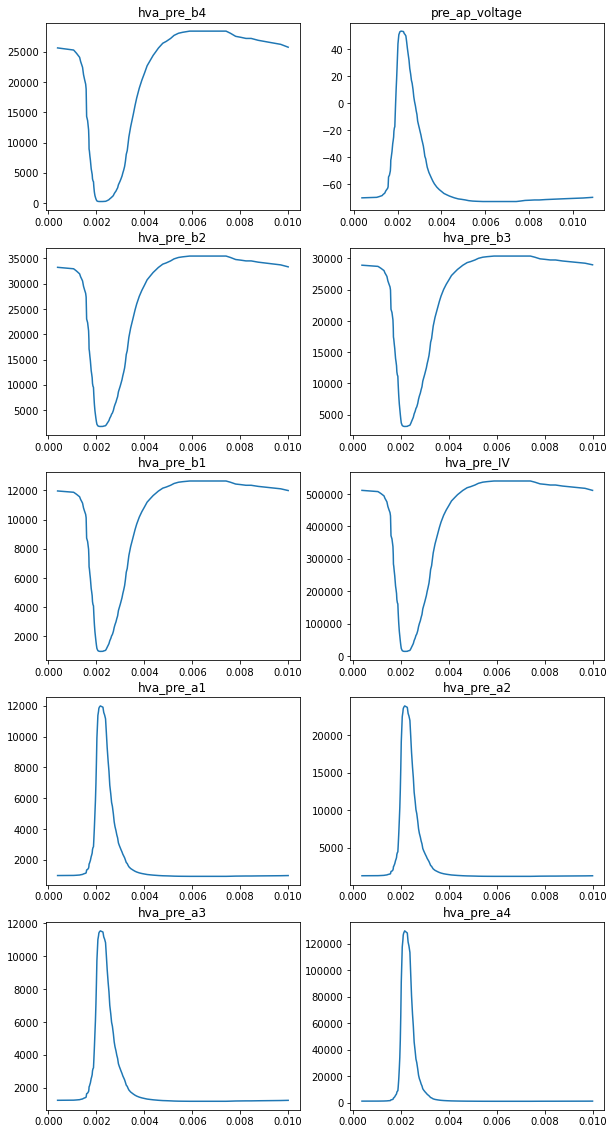

In [9]:
# Plot all the waveforms
fig, ax = plt.subplots(5, 2, figsize = (10,20))

for a, (key, value) in zip(ax.flatten(), input_data.items()):
    a.plot(value[:,0], value[:,1])
    a.set_title(key)

### Transition functions

In [10]:
# Temperature adjustment from paper
q10 = 2.0  # rxn rate increase with 10 degC temp change; assumuption of uniform q10 for all reactions here
delta_temp = 10.0  # parameters are given at 24C so raise temp by 10C to 34C (rat internal temp)
temp_comp = q10 ** (delta_temp / 10.)  # change in rxn rate due to deltaT eqtn

In [11]:
# All in units of ms

# 1st transition
v1 = 49.14          # mV
def alpha_1(t):
    '''
    alpha 1 forward transition rate
    parameters:     time (t)      int/double value or array
    returns:        equation for alpha_1
    '''
    
    a1o = 4.04          # msec-1
    #adjust = 0.5        # changes by Tom and Suhita
    adjust = 1
    
    return adjust * temp_comp * a1o * np.exp(v_m(t)/v1)

def beta_1(t):
    '''
    beta 1 backward transition rate
    parameters:     time (t)      int/double value or array
    returns:        equation for beta_1
    '''
    
    b1o = 2.88          # msec-1
    #adjust = 0.5
    adjust = 1
    
    return adjust * temp_comp * b1o * np.exp(-v_m(t)/v1) 

# 2nd transition
v2 = 42.08          # mV
def alpha_2(t):
    '''
    alpha 2 forward transition rate
    parameters:     time (t)      int/double value or array
    returns:        equation for alpha_2
    '''
       
    a2o = 6.70          # msec-1
    #adjust = 0.5        # changes by Tom and Suhita
    adjust = 1
    
    return adjust * temp_comp * a2o * np.exp(v_m(t)/v2)

def beta_2(t):
    '''
    beta 2 backward transition rate
    parameters:     time (t)      int/double value or array
    returns:        equation for beta_2
    '''
    
    b2o = 6.30          # msec-1
    #adjust = 0.5
    adjust = 1
    
    return adjust * temp_comp * b2o * np.exp(-v_m(t)/v2) 

# 3rd transition
v3 = 55.31          # mV
def alpha_3(t):
    '''
    alpha 3 forward transition rate
    parameters:     time (t)      int/double value or array
    returns:        equation for alpha_3
    '''
    
    a3o = 4.39          # msec-1
    #adjust = 0.5        # changes by Tom and Suhita
    adjust = 1
    
    return adjust * temp_comp * a3o * np.exp(v_m(t)/v3)

def beta_3(t):
    '''
    beta 3 backward transition rate
    parameters:     time (t)      int/double value or array
    returns:        equation for beta_3
    '''
    
    b3o = 8.16          # msec-1
    #adjust = 0.5
    adjust = 1
    
    return adjust * temp_comp * b3o * np.exp(-v_m(t)/v3) 

# 4th transition
v4 = 26.55          # mV
def alpha_4(t):
    '''
    alpha 4 forward transition rate
    parameters:     time (t)      int/double value or array
    returns:        equation for alpha_4
    '''
    
    a4o = 17.33         # msec-1
    #adjust = 0.5        # changes by Tom and Suhita
    adjust = 1
    
    return adjust * temp_comp * a4o * np.exp(v_m(t)/v4)

def beta_4(t):
    '''
    beta 4 backward transition rate
    parameters:     time (t)      int/double value or array
    returns:        equation for beta_4
    '''
    
    b4o = 1.84          # msec-1
    #adjust = 0.5
    adjust = 1
    
    return adjust * temp_comp * b4o * np.exp(-v_m(t)/v4) 

## Single channel Markov sampling

In [12]:
# Simulate Markov process for stochastically opening and closing channels

def markov_vdcc(trange,dt):
    '''
    Function to simulate to opening and closing of vdcc channels as a Markov process

    input:    number of channels (n) [int]
              time (trange)          [int/double or 1d array]
              time step (dt)         [int/double]

    output:   fraction of open channels over time (output) [1d array]
    '''  
    # Create transition probability matrix
    
    states = np.zeros(len(trange), dtype=int)
    
    for t_index in range(1, len(trange)):
        # create appropriate transition matrix (MAKE PATTERN LATER)
        if states[t_index - 1] == 0:
            p_trans = [1 - alpha_1(trange[t_index])*dt, alpha_1(trange[t_index])*dt, 0, 0, 0]
        
        elif states[t_index - 1] == 1:
            p_trans = [beta_1(trange[t_index])*dt, 1 - (beta_1(trange[t_index])*dt + alpha_2(trange[t_index])*dt), 
                       alpha_2(trange[t_index])*dt, 0, 0]
            
        elif states[t_index - 1] == 2:
            p_trans = [0, beta_2(trange[t_index])*dt, 1 - (beta_2(trange[t_index])*dt + alpha_3(trange[t_index])*dt), 
                       alpha_3(trange[t_index])*dt, 0]
            
        elif states[t_index - 1] == 3:
            p_trans = [0, 0, beta_3(trange[t_index])*dt, 1 - (beta_3(trange[t_index])*dt + alpha_4(trange[t_index])*dt), 
                       alpha_4(trange[t_index])*dt]
            
        elif states[t_index - 1] == 4:
            p_trans = [0, 0, 0, beta_4(trange[t_index])*dt, 1 - beta_4(trange[t_index])*dt]
            
        states[t_index] = list(np.random.multinomial(1, p_trans)).index(1)
        
    n_open = np.zeros(len(trange), dtype=int)
    for t_index in range(len(trange)):
        if states[t_index] == 4:
            n_open[t_index] = 1
        
    return states, n_open
      

In [13]:
dt = 1e-3
trange = np.arange(0, 11, 1e-3)
states, n_open = markov_vdcc(trange, dt)

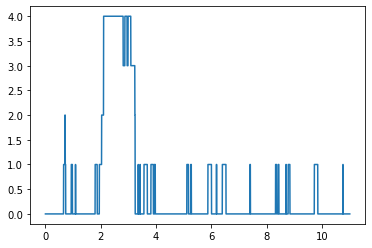

In [14]:
plt.plot(trange,states)
plt.show()

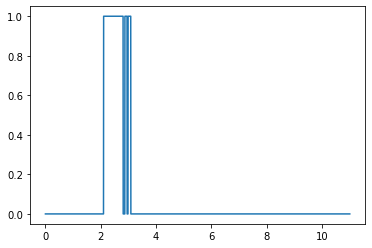

In [15]:
plt.plot(trange,n_open)
plt.show()

## Inefficient multichannel Markov

In [17]:
# Simulate Markov process for stochastically opening and closing channels

def markov_vdcc_n_single(n_channels,trange,dt):
    '''
    Function to simulate to opening and closing of vdcc channels as a Markov process

    input:    number of channels (n) [int]
              time (trange)          [int/double or 1d array]
              time step (dt)         [int/double]

    output:   fraction of open channels over time (output) [1d array]
    '''  
    # Create transition probability matrix
    
    states = np.zeros((n_channels, len(trange)), dtype=int)
    n0 = np.zeros(len(trange), dtype=int)
    n1 = np.zeros(len(trange), dtype=int)
    n2 = np.zeros(len(trange), dtype=int)
    n3 = np.zeros(len(trange), dtype=int)
    n4 = np.zeros(len(trange), dtype=int)
    
    for t_index in range(1, len(trange)):
        for chan_i in range(n_channels):
            if states[chan_i, t_index - 1] == 0:
                p_trans = [1 - alpha_1(trange[t_index])*dt, alpha_1(trange[t_index])*dt, 0, 0, 0]

            elif states[chan_i, t_index - 1] == 1:
                p_trans = [beta_1(trange[t_index])*dt, 1 - (beta_1(trange[t_index])*dt + alpha_2(trange[t_index])*dt), 
                           alpha_2(trange[t_index])*dt, 0, 0]

            elif states[chan_i, t_index - 1] == 2:
                p_trans = [0, beta_2(trange[t_index])*dt, 1 - (beta_2(trange[t_index])*dt + alpha_3(trange[t_index])*dt), 
                           alpha_3(trange[t_index])*dt, 0]

            elif states[chan_i, t_index - 1] == 3:
                p_trans = [0, 0, beta_3(trange[t_index])*dt, 1 - (beta_3(trange[t_index])*dt + alpha_4(trange[t_index])*dt), 
                           alpha_4(trange[t_index])*dt]

            elif states[chan_i, t_index - 1] == 4:
                p_trans = [0, 0, 0, beta_4(trange[t_index])*dt, 1 - beta_4(trange[t_index])*dt]

            states[chan_i, t_index] = list(np.random.multinomial(1, p_trans)).index(1)
            
        num = np.count_nonzero(states[:, t_index] == 0)
        n0[t_index] = num
        
        num = np.count_nonzero(states[:, t_index] == 1)
        n1[t_index] = num
        
        num = np.count_nonzero(states[:, t_index] == 2)
        n2[t_index] = num
        
        num = np.count_nonzero(states[:, t_index] == 3)
        n3[t_index] = num
        
        num = np.count_nonzero(states[:, t_index] == 4)
        n4[t_index] = num
        
    return states, n0, n1, n2, n3, n4

In [18]:
# Simulation is in ms
# MCell equivalent is 10ms (0.01s) at timestep of 1e-6s (1e-3ms)
dt = 1e-3
t_start = 0
t_stop = 10
n_vdcc = 65
trange = np.arange(t_start, t_stop+dt, dt)
states, n0, n1, n2, n3, n4 = markov_vdcc_n_single(n_vdcc, trange, dt)


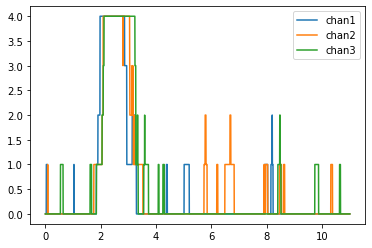

In [33]:
plt.plot(trange,states[0,:], label='chan1')
plt.plot(trange, states[1,:], label='chan2')
plt.plot(trange, states[2,:], label='chan3')
plt.legend()
plt.show()

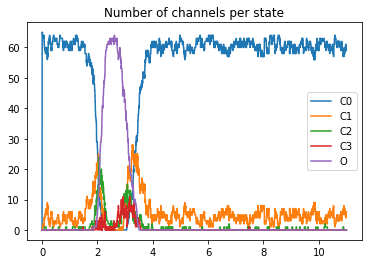

In [34]:
plt.plot(trange,n0, label='C0')
plt.plot(trange,n1, label='C1')
plt.plot(trange,n2, label='C2')
plt.plot(trange,n3, label='C3')
plt.plot(trange,n4, label='O')
plt.title("Number of channels per state")
plt.legend()
plt.show()

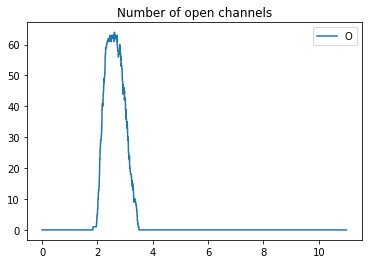

In [35]:
plt.plot(trange,n4, label='O')
plt.title("Number of open channels")
plt.legend()
plt.show()

## Benchmarking runtime

In [19]:
dt = 1e-3
t_start = 0
t_stop = 10
n_vdcc = 65
trange = np.arange(t_start, t_stop+dt, dt)

%timeit -n 1 -r 10 markov_vdcc_n_single(n_vdcc, trange, dt)

50.3 s ± 761 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [36]:
#%timeit markov_vdcc_n_single(65, trange, dt) (uncomment to run)
# output: 1min 17s ± 2.28 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [37]:
#%timeit markov_vdcc_n(65, trange, dt)
# output: 7.54 s ± 100 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Looping and sampling each channel took 1min 17s while multinomial sampling took 7.54s (10x faster).